In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
dataset = np.load('./mnist_test_seq.npy')

In [3]:
print(f'Shape {dataset.shape}')
print(f'Num of Frames {dataset.shape[0]}')
print(f'Num of Samples {dataset.shape[1]}')

Shape (20, 10000, 64, 64)
Num of Frames 20
Num of Samples 10000


In [4]:
# swap the axis frame and samples
dataset = np.swapaxes(dataset, 0, 1)
print(f'Shape {dataset.shape}')

Shape (10000, 20, 64, 64)


In [5]:
#  1000 samples
dataset = dataset[:1000, ...]
print(f'Shape {dataset.shape}')

Shape (100, 20, 64, 64)


In [6]:
# add dim at the end as channel
dataset = np.expand_dims(dataset, axis=-1)
print(f'Shape {dataset.shape}')

Shape (100, 20, 64, 64, 1)


In [7]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]
print(f'train {train_dataset.shape} test {val_dataset.shape}')

train (90, 20, 64, 64, 1) test (10, 20, 64, 64, 1)


In [8]:
# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255.0
val_dataset = val_dataset / 255.0

In [9]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [10]:
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (90, 19, 64, 64, 1), (90, 19, 64, 64, 1)
Validation Dataset Shapes: (10, 19, 64, 64, 1), (10, 19, 64, 64, 1)


Displaying frames for example 51.


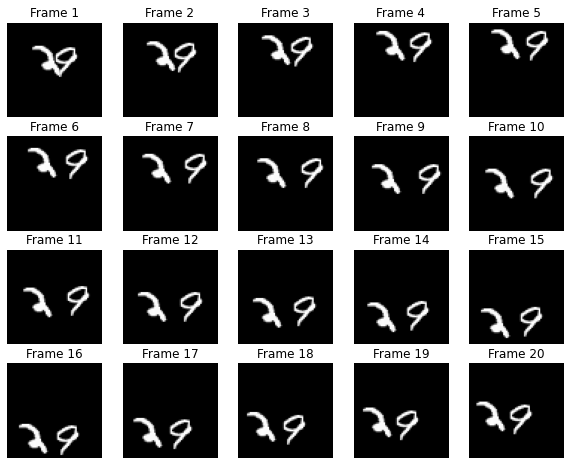

In [11]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [12]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 64, 64, 1)] 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 64, 64, 64)  33024     
_________________________________________________________________
conv3d (Conv3D)              (None, None, 64, 64, 1)   1729  

In [20]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 5
batch_size = 3

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/5
30/30 [==============================] - 40s 1s/step - loss: 0.0353 - val_loss: 0.2323
Epoch 2/5
30/30 [==============================] - 35s 1s/step - loss: 0.0328 - val_loss: 0.2329
Epoch 3/5
30/30 [==============================] - 37s 1s/step - loss: 0.0319 - val_loss: 0.2361
Epoch 4/5
30/30 [==============================] - 34s 1s/step - loss: 0.0310 - val_loss: 0.2429
Epoch 5/5
30/30 [==============================] - 34s 1s/step - loss: 0.0308 - val_loss: 0.2489


In [25]:
# model.save('model.h5')
# model = tf.keras.models.load_model('model.h5')

In [26]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

In [27]:
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

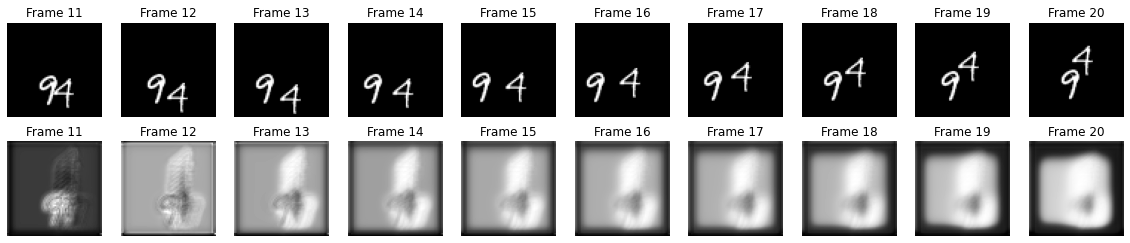

In [28]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()